In [53]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from sklearn.manifold import TSNE





import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
df = pd.read_csv('Restaurant_reviews.csv')
df.tail()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0,NaN
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,NaN
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,NaN
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0,NaN
9999,Chinese Pavilion,Bhargava Krishna,Checked in here to try some delicious chinese ...,3.5,"472 Reviews , 1302 Followers",5/31/2016 16:41,6,NaN


In [37]:
df.dtypes

Restaurant     object
Reviewer       object
Review         object
Rating         object
Metadata       object
Time           object
Pictures        int64
7514          float64
dtype: object

In [38]:
df.drop('7514', axis=1, inplace=True)
df.drop('Pictures', axis=1, inplace=True)
df.isnull().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
dtype: int64

In [39]:
df.dropna(inplace=True)
df.isnull().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
dtype: int64

In [40]:
restaurant_counts = df['Restaurant'].value_counts()

num_restaurants = len(restaurant_counts)
print(f"There are {num_restaurants} unique restaurants in the list.")
mean_reviews_per_restaurant = restaurant_counts.mean()
print(f"The mean number of reviews per restaurant is {round(mean_reviews_per_restaurant):.2f}.")


There are 100 unique restaurants in the list.
The mean number of reviews per restaurant is 100.00.


In [41]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')


df.dropna(subset=['Rating'], inplace=True)




mean_ratings = df.groupby('Restaurant')['Rating'].mean()

highest_rating_restaurant = mean_ratings.idxmax()
highest_rating = mean_ratings.max()

lowest_rating_restaurant = mean_ratings.idxmin()
lowest_rating = mean_ratings.min()

print(f"The restaurant with the highest mean rating is {highest_rating_restaurant} with a rating of {highest_rating:.2f}.")
print(f"The restaurant with the lowest mean rating is {lowest_rating_restaurant} with a rating of {lowest_rating:.2f}.")


The restaurant with the highest mean rating is AB's - Absolute Barbecues with a rating of 4.88.
The restaurant with the lowest mean rating is Hotel Zara Hi-Fi with a rating of 2.40.


In [42]:

highest_rated_reviews = df[df['Restaurant'] == highest_rating_restaurant]
lowest_rated_reviews = df[df['Restaurant'] == lowest_rating_restaurant]


rest_of_reviews = df[~df['Restaurant'].isin([highest_rating_restaurant, lowest_rating_restaurant])]
sampled_reviews = rest_of_reviews.sample(frac=0.5, random_state=42)
rest_df = pd.concat([highest_rated_reviews, lowest_rated_reviews, sampled_reviews])

print(f"Reduced dataset size: {len(rest_df)}")

Reduced dataset size: 5077


In [43]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    else:
        text = ''
    return text


rest_df['preprocess_review'] = rest_df['Review'].apply(preprocess_text)


In [44]:
all_reviews = ' '.join(rest_df['preprocess_review'])
word_counts = Counter(all_reviews.split())


print(word_counts.most_common(20))



[('good', 3622), ('food', 3496), ('place', 3014), ('service', 1711), ('chicken', 1616), ('taste', 1268), ('ordered', 1165), ('one', 1083), ('ambience', 1038), ('time', 1030), ('great', 1021), ('really', 827), ('also', 815), ('restaurant', 785), ('staff', 742), ('nice', 741), ('best', 741), ('like', 734), ('biryani', 729), ('order', 692)]


In [45]:
words_to_remove = ['good', 'food', 'place', 'service', 'chicken', 'taste', 'ordered', 'one',
                    'ambience', 'time']


def remove_words(text, words_to_remove):
    return ' '.join([word for word in text.split() if word not in words_to_remove])


rest_df['preprocess_review'] = rest_df['preprocess_review'].apply(lambda text: remove_words(text, words_to_remove))


In [46]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(rest_df['preprocess_review']).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


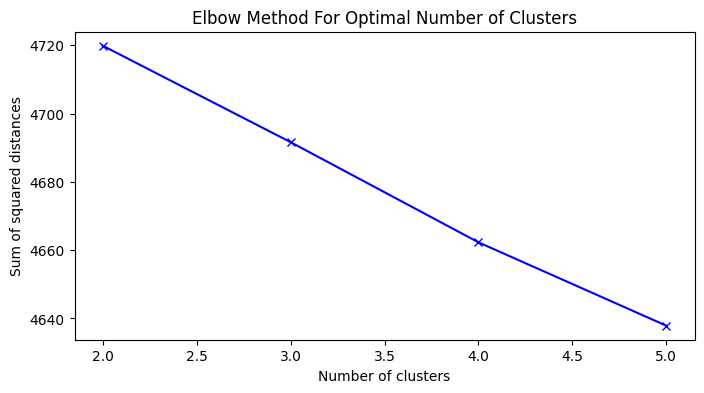

In [47]:
sum_of_squared_distances = []
K = range(2, 6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sum_of_squared_distances.append(kmeans.inertia_)


plt.figure(figsize=(8, 4))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=2: 0.024679507177961364


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=3: 0.01985018150809537


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=4: 0.019850990082162828


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=5: 0.018833608689729744


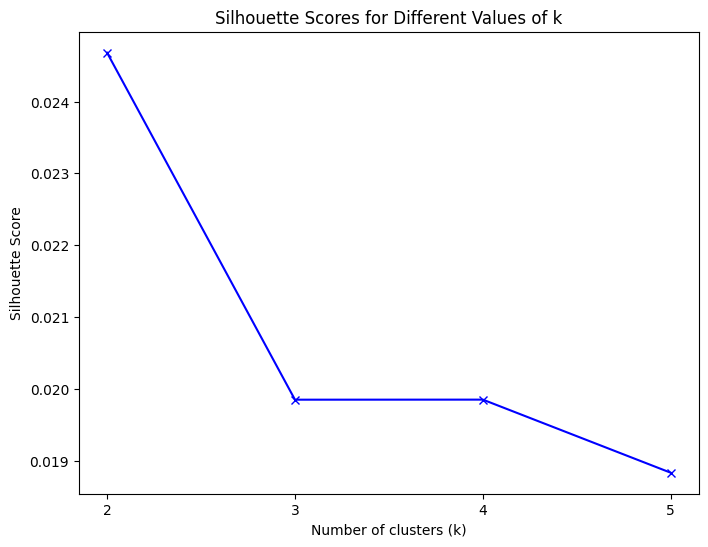

In [48]:
silhouette_scores = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score for k={k}: {silhouette_avg}")

plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of k')
plt.xticks(K_range)
plt.show()


In [49]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)


rest_df['cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


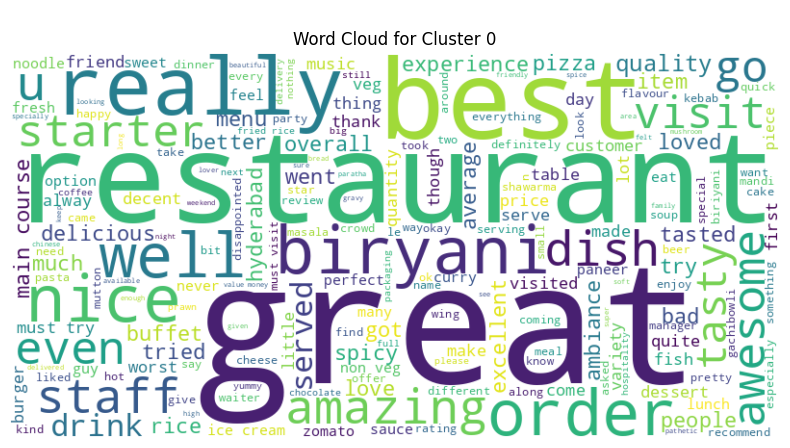

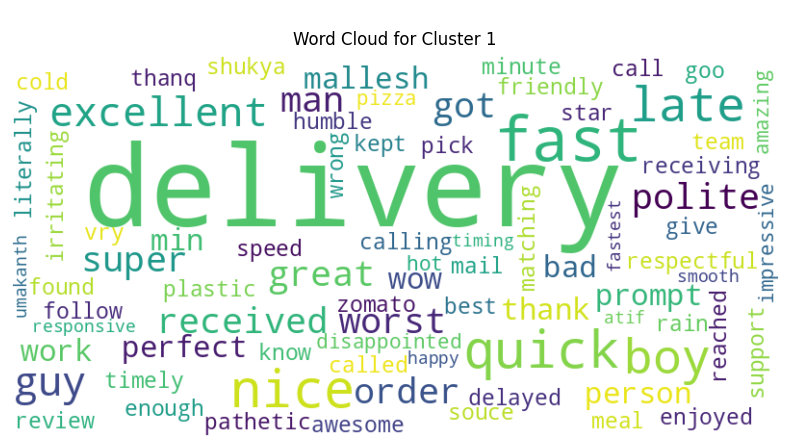

In [50]:
# Generate and plot a word cloud for each cluster
for i in range(num_clusters):
    cluster_reviews = ' '.join(rest_df[rest_df['cluster'] == i]['preprocess_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'\nWord Cloud for Cluster {i}')
    plt.axis('off')
    plt.show()


In [51]:
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(rest_df[rest_df['cluster'] == i]['Review'].head())
    print("\n")


Cluster 0:
1400    It was excellent experience spiced thank Krish...
1401    Excellent, it was a great experience that i ha...
1402    Visited AB’s 3rd time and as always staff was ...
1403    Varun and sandeep done excellent job\n..awesom...
1404    Excellent food and excellent service by mr Kri...
Name: Review, dtype: object


Cluster 1:
1769                                     Delivery on time
1797                                  good speed delivery
971     Delivery was before time. 5 star for delivery ...
8699    late delivery. plastic found in food. Bad serv...
5869                                     delivery in rain
Name: Review, dtype: object




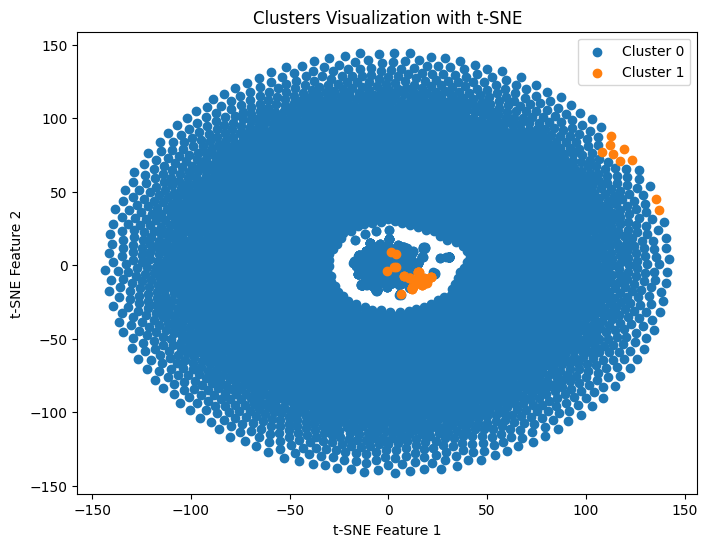

In [54]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)


plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(X_embedded[clusters == i, 0], X_embedded[clusters == i, 1], label=f'Cluster {i}')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('Clusters Visualization with t-SNE')
plt.legend()
plt.show()


In [56]:
rest_df['review_pos_neg'] = rest_df['Rating'].apply(lambda x: 'positive' if x >= 3 else 'negative')
encoder = LabelEncoder()
y = encoder.fit_transform(rest_df['review_pos_neg'])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8858267716535433
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.59      0.72       384
           1       0.88      0.98      0.93      1140

    accuracy                           0.89      1524
   macro avg       0.90      0.79      0.83      1524
weighted avg       0.89      0.89      0.88      1524



## positive

In [63]:
def predict_sentiment(review, model, vectorizer, encoder):
    preprocessed_review = preprocess_text(review)
    review_vector = vectorizer.transform([preprocessed_review]).toarray()
    prediction_numeric = model.predict(review_vector)
    prediction_label = encoder.inverse_transform(prediction_numeric)[0]

    return prediction_label


new_review = "The food was amazing and the service was excellent!"
predicted_sentiment = predict_sentiment(new_review, model, vectorizer, encoder)
predicted_sentiment


'positive'

## negative

In [65]:
def predict_sentiment(review, model, vectorizer, encoder):
    preprocessed_review = preprocess_text(review)
    review_vector = vectorizer.transform([preprocessed_review]).toarray()
    prediction_numeric = model.predict(review_vector)
    prediction_label = encoder.inverse_transform(prediction_numeric)[0]

    return prediction_label


new_review = "The service was terrible and the food was cold!"
predicted_sentiment = predict_sentiment(new_review, model, vectorizer, encoder)
predicted_sentiment

'negative'

## Try yourself

In [64]:
def predict_sentiment(review, model, vectorizer, encoder):
    preprocessed_review = preprocess_text(review)
    review_vector = vectorizer.transform([preprocessed_review]).toarray()
    prediction_numeric = model.predict(review_vector)
    prediction_label = encoder.inverse_transform(prediction_numeric)[0]

    return prediction_label




new_review = input()
predicted_sentiment = predict_sentiment(new_review, model, vectorizer, encoder)
predicted_sentiment


"The food was amazing and the service was excellent!"


'positive'